In [1]:
import torch
import torchvision.datasets as dsets
from torchvision import transforms
import random
import matplotlib.pyplot as plt


# check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# set seed for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

torch.__version__, device

('1.7.0+cu101', 'cuda')

In [2]:
def train(data_loader, n_epochs, model, criterion, optimizer):
  total_batch = len(data_loader)
  model.train()    # set the model to train mode (dropout=True)

  for epoch in range(n_epochs):
    avg_cost = 0

    for x_train, y_train in data_loader:
      x_train = x_train.view(-1, 28*28).to(device)
      y_train = y_train.to(device)

      hypothesis = model(x_train)
      cost = criterion(hypothesis, y_train)

      optimizer.zero_grad()
      cost.backward()
      optimizer.step()
      
      avg_cost += cost / total_batch
      
    if epoch%1 == 0:
      print(f'epoch : {epoch:3}  |  cost : {avg_cost:10.6f}')


def test(mnist_test, device, model):
  model.eval()    # set the model to evaluation mode (dropout=False)

  # compute accuracy
  with torch.no_grad():
    x_test = mnist_test.data.view(-1, 28*28).float().to(device)
    y_test = mnist_test.targets.to(device)

    prediction = model(x_test)
    correct_prediction = torch.argmax(prediction, 1) == y_test
    accuracy = correct_prediction.float().mean()
    print('>>> Test Accuracy:', accuracy.item())

## Dropout
- Dropout : Overfitting을 방지하기 위한 방법 중 하나로, 학습 시 매 layer에서 일정 비율의 노드를 제외하는 것
- 학습이 완료된 이후 추론(예측) 시에는 Dropout 적용하지 않고 전체 노드 사용 - `model.train()`, `model.eval()`

In [3]:
# set parameters
batch_size = 100
n_epochs = 15
learning_rate = 0.001
drop_prob = 0.3

# prepare data
mnist_train = dsets.MNIST(root='mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = dsets.MNIST(root='mnist_data/', train=False, transform=transforms.ToTensor(), download=True)
data_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
%%time

# generate layers - larger model
linear1 = torch.nn.Linear(28*28, 512, bias=True).to(device)
linear2 = torch.nn.Linear(512, 512, bias=True).to(device)
linear3 = torch.nn.Linear(512, 512, bias=True).to(device)
linear4 = torch.nn.Linear(512, 512, bias=True).to(device)
linear5 = torch.nn.Linear(512, 10, bias=True).to(device)
relu = torch.nn.ReLU()
dropout = torch.nn.Dropout(p=drop_prob)

# initialize weights
for layer in [linear1, linear2, linear3, linear4, linear5]:
  torch.nn.init.xavier_normal_(layer.weight)  # Xavier Initialization

# build model
model = torch.nn.Sequential(
    linear1, relu, dropout,
    linear2, relu, dropout,
    linear3, relu, dropout,
    linear4, relu, dropout,
    linear5
)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss().to(device)  # Softmax is internally computed

# train model
train(data_loader, n_epochs, model, criterion, optimizer)

# test model
test(mnist_test, device, model)



epoch :   0  |  cost :   0.312234
epoch :   1  |  cost :   0.143634
epoch :   2  |  cost :   0.113312
epoch :   3  |  cost :   0.094885
epoch :   4  |  cost :   0.084360
epoch :   5  |  cost :   0.076371
epoch :   6  |  cost :   0.064357
epoch :   7  |  cost :   0.062262
epoch :   8  |  cost :   0.058257
epoch :   9  |  cost :   0.053716
epoch :  10  |  cost :   0.052059
epoch :  11  |  cost :   0.048765
epoch :  12  |  cost :   0.047818
epoch :  13  |  cost :   0.047645
epoch :  14  |  cost :   0.044285
>>> Test Accuracy: 0.9817999601364136
CPU times: user 2min 21s, sys: 1.34 s, total: 2min 23s
Wall time: 2min 30s


Label: 8
Prediction :  8


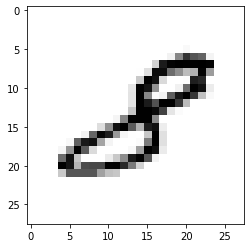




Label: 5
Prediction :  5


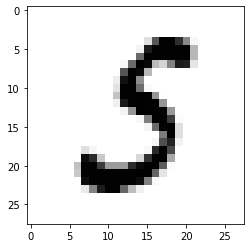




Label: 7
Prediction :  7


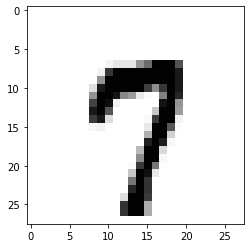




Label: 9
Prediction :  9


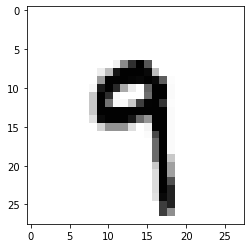




Label: 3
Prediction :  3


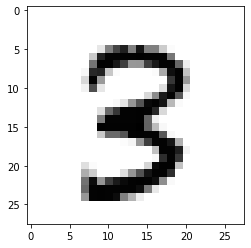

In [5]:
# visualization
for i in range(5):
  r = random.randint(0, len(mnist_test)-1) # 0~9999까지 랜덤한 정수
  X_single_data = mnist_test.data[r].view(-1, 28*28).float().to(device)
  Y_single_data = mnist_test.targets[r].to(device)

  single_prediction = model(X_single_data)
  print('Label:', Y_single_data.item())
  print('Prediction : ', torch.argmax(single_prediction, 1).item())

  plt.imshow(mnist_test.data[r].view(28,28), cmap='Greys', interpolation='nearest')
  plt.show()

  print('\n\n')